# Debug ellipse angle loss

In [1]:
import os
import sys
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
lib_path = os.path.join('../src/lib')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = os.path.join('../src/')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
from models.losses import RegL1Loss4Angle

In [25]:
a1 = 180 / 180 * math.pi
a2 = -90 / 180 * math.pi

pred_angle = torch.tensor(a1)
true_angle = torch.tensor(a2)
diff_angle = pred_angle - true_angle
sin, cos = torch.sin(diff_angle), torch.cos(diff_angle)
mask = torch.ones_like(cos)
mask(cos < 0) = 1
loss = torch.atan2(sin, cos) if cos >=0 else torch.atan2(-sin, -cos)
print(diff_angle, sin, cos, loss)

tensor(4.7124) tensor(-1.) tensor(1.1925e-08) tensor(-1.5708)


In [98]:
def angle_loss(pred_angle, true_angle, size_average=False):
    diff_angle = (pred_angle - true_angle) * math.pi
    sin, cos = torch.sin(diff_angle), torch.cos(diff_angle)
    mask = torch.ones_like(cos)
    mask[cos < 0] = -1
    sin, cos = sin * mask, cos * mask
    loss = F.l1_loss(torch.atan2(sin, cos), torch.zeros_like(sin), size_average=False) #if cos >=0 else torch.atan2(-sin, -cos)
    return loss

In [72]:
pred_angle = torch.tensor(0.4)
true_angle = torch.tensor(1)
diff_angle = (pred_angle - true_angle) * math.pi
angle_loss(pred_angle, true_angle)

tensor(1.2566)

In [89]:
np.mean(np.abs([1.2566e+00,  1.2566e+00, -1.5708e+00, -8.7423e-08, -1.5708e+00, 1.5708e+00]))

1.2042666812371667

In [4]:
pred_angle = torch.tensor([1,    1,    2,  0,  1, 0.5])
true_angle = torch.tensor([-0.4, 0.6, 0.5, 1, 0.5, 1])
diff_angle = (pred_angle - true_angle) * math.pi
sin, cos = torch.sin(diff_angle), torch.cos(diff_angle)
angle_loss(pred_angle, true_angle)
# tensor([ 1.2566e+00,  1.2566e+00, -1.5708e+00, -8.7423e-08, -1.5708e+00, 1.5708e+00])

In [31]:
def _gather_feat(feat, ind, mask=None):
    dim  = feat.size(2)
    ind  = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat

def _transpose_and_gather_feat(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feat(feat, ind)
    return feat

In [6]:
ind = torch.tensor(np.random.randint(0, 10, [16, 2])) 
mask = torch.tensor(np.ones([16, 2])) 
target = torch.tensor(np.ones([16, 2, 1])) * 0.5 
feat = torch.tensor(np.zeros([16, 1, 128, 128]))
print(feat.shape, mask.shape, ind.shape, target.shape)
# feat = feat.permute(0, 2, 3, 1).contiguous() # (16, 128, 128, 1)
# feat = feat.view(feat.size(0), -1, feat.size(3)) # （16, 16384, 1）
# feat = _gather_feat(feat, ind) # (16, 2, 1)
# feat.shape

torch.Size([16, 1, 128, 128]) torch.Size([16, 2]) torch.Size([16, 2]) torch.Size([16, 2, 1])


In [100]:
class RegL1Loss(nn.Module):
  def __init__(self):
    super(RegL1Loss, self).__init__()
  
  def forward(self, output, mask, ind, target):
    pred = _transpose_and_gather_feat(output, ind)
    mask = mask.unsqueeze(2).expand_as(pred).float()
    # loss = F.l1_loss(pred * mask, target * mask, reduction='elementwise_mean')
    loss = F.l1_loss(pred * mask, target * mask, size_average=False)
    loss = loss / (mask.sum() + 1e-4)
    return loss

class RegL1Loss4Angle(nn.Module):
  def __init__(self):
    super(RegL1Loss4Angle, self).__init__()
  
  def forward(self, output, mask, ind, target):
    pred = _transpose_and_gather_feat(output, ind)
    mask = mask.unsqueeze(2).expand_as(pred).float()
    # loss = F.l1_loss(pred * mask, target * mask, reduction='elementwise_mean')
    loss = angle_loss(pred * mask, target * mask, size_average=False)
    loss = loss / (mask.sum() + 1e-4)
    return loss

In [65]:
%pdb off

Automatic pdb calling has been turned OFF


In [8]:
RegL1Loss4Angle(True)(feat, mask, ind, target)

tensor(1.0708, dtype=torch.float64)

In [37]:
feat = torch.tensor(np.ndarray([16, 2, 128, 128]))
mask = torch.tensor(np.zeros([16, 1, 128, 128]))
feat.shape, mask.shape

(torch.Size([16, 2, 128, 128]), torch.Size([16, 1, 128, 128]))

In [ ]:
class RegL1Loss(nn.Module):
  def __init__(self):
    super(RegL1Loss, self).__init__()
  
  def forward(self, output, mask, ind, target):
    pred = _transpose_and_gather_feat(output, ind)
    mask = mask.unsqueeze(2).expand_as(pred).float()
    # loss = F.l1_loss(pred * mask, target * mask, reduction='elementwise_mean')
    loss = F.l1_loss(pred * mask, target * mask, size_average=False)
    loss = loss / (mask.sum() + 1e-4)
    return loss

In [1]:
# Calculate Metrics: Dice and difference of angles
# input 2 ellipse ell1, ell2 in [cx, cy, a, b, angle], image shape [h, w], num_classes

def compute_dice(pred, label):
    
    ints = np.sum((pred == 1) * (label == 1))
    sums = np.sum(pred == 1) + np.sum(label == 1) + 1e-5
    
    return (2.0 * ints) / sums

def compute_iou(pred, label):
    
    inter = np.sum((pred == 1) * (label == 1))
    union = np.sum((pred == 1) + (label == 1)) + 1e-5
    
    return inter / union

def compute_rotated_bbox_iou(ell1, ell2):
    cx1, cy1, a1, b1, angle1 = ell1
    cx2, cy2, a2, b2, angle2 = ell2
    theta1 = angle1 / 180.0 * math.pi
    theta2 = angle2 / 180.0 * math.pi
    bbox1 = torch.tensor([[[cx1, cy1, 2 * a1, 2 * b1, theta1]]], dtype=torch.float).cuda()
    bbox2 = torch.tensor([[[cx2, cy2, 2 * a2, 2 * b2, theta2]]], dtype=torch.float).cuda()
    return cal_diou(bbox1, bbox2) # iou_loss, iou

def compute_single_class_metric(ell1, ell2, shape):
    cx1, cy1, a1, b1, angle1 = ell1
    cx2, cy2, a2, b2, angle2 = ell2
    h, w = shape
    pred = np.zeros([h, w], np.uint8)
    pred = cv2.ellipse(pred, (cx1, cy1), (int(a1), int(b1)), int(angle1), 0.0, 360.0, (1), thickness=-1)
    label = np.zeros([h, w], np.uint8)
    label = cv2.ellipse(label, (cx2, cy2), (int(a2), int(b2)), int(angle2), 0.0, 360.0, (1), thickness=-1)
    angle_error = abs(angle1 - angle2)
    angle_error = angle_error if angle_error <= 90 else (180 - angle_error)
    bbox_iou_loss, bbox_iou = compute_rotated_bbox_iou(ell1, ell2)
    return compute_dice(pred, label), compute_iou(pred, label), bbox_iou.item(), angle_error

# Debug IoU Loss

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import math
from glob import glob

lib_path = os.path.join('../src/lib')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = os.path.join('../src/')
if not lib_path in sys.path:
    sys.path.append(lib_path)

import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import cv2
from PIL import Image

from utils.image import flip, color_aug
from utils.image import get_affine_transform, affine_transform
from utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian
from utils.image import draw_dense_reg
from fhd_opts import opts
from datasets.dataset_factory import get_dataset
# from models.decode import decode_output_4iou, decode_label_4iou

from detectors.detector_factory import detector_factory
from models.losses import IoULoss, decode_output_4iou, decode_label_4iou, cal_diou, IoULossSincos

In [4]:
args = ['eldet']
opt = opts().parse(args)
opt.data_dir = '/data/cc/Data/CHD/detection/'
opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/0218_exp1_iou0_896x608//model_last.pth'
opt.num_classes = 2
opt.dataset = 'coco_fhd'
opt.not_rand_crop = True
opt.input_h = 608
opt.input_w = 896
opt.resume = True
opt.batch_size = 1

torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

print(opt)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default
heads {'hm': 2, 'reg': 2, 'l': 1, 'ratio_al': 1, 'ratio_bl': 1, 'theta': 1, 'sincos': 2}
Namespace(K=2, aggr_weight=0.0, agnostic_ex=False, angle_bins_weight=0, arch='dla_34', aug_ddd=0.5, aug_rot=0, batch_size=1, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/cc/Data/CHD/detection/', dataset='coco_fhd', debug=0, debug_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default/debug', debugger_theme='white', demo='', dense_hp=False, dense_wh=False, dep_weight=1, dim_weight=1, down_ratio=4, ellipse_reg_weight=0, ellipse_weight=1, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet', exp_id='default', fix_res=True, 

In [5]:
print('Setting up data...')

dataset = Dataset(opt, 'val')

val_loader = torch.utils.data.DataLoader(
    Dataset(opt, 'val'), 
    batch_size=1, 
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

if opt.test:
    _, preds = trainer.val(0, val_loader)
    val_loader.dataset.run_eval(preds, opt.save_dir)

train_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=16, 
    shuffle=False,
    num_workers=opt.num_workers,
    pin_memory=True,
    drop_last=True
)

Detector = detector_factory[opt.task]
opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/0218_exp1_iou0_896x608/model_last.pth'
detector = Detector(opt)

Setting up data...
==> initializing Fetal Heart Disease val data.
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loaded val 417 samples
==> initializing Fetal Heart Disease val data.
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loaded val 417 samples
Creating model...


FileNotFoundError: [Errno 2] No such file or directory: '/data/cc/workspace/Repository/CenterNet/exp/eldet/0218_exp1_iou0_896x608/model_last.pth'

In [12]:
print(len(dataset))
for iter_id, batch in enumerate(train_loader): # len(batch) = 6
    break


232


0 255 57.212716238839285
Ground Truth: (215, -6) (708, 486) (462, 240) tensor([492.3202]) tensor([0.8084]) tensor([0.5850]) (tensor([-0.0075]))' 199 144 -1
Ground Truth: (414, 93) (671, 350) (543, 222) tensor([256.1856]) tensor([0.8431]) tensor([0.5309]) (tensor([-0.0629]))' 108 68 -11


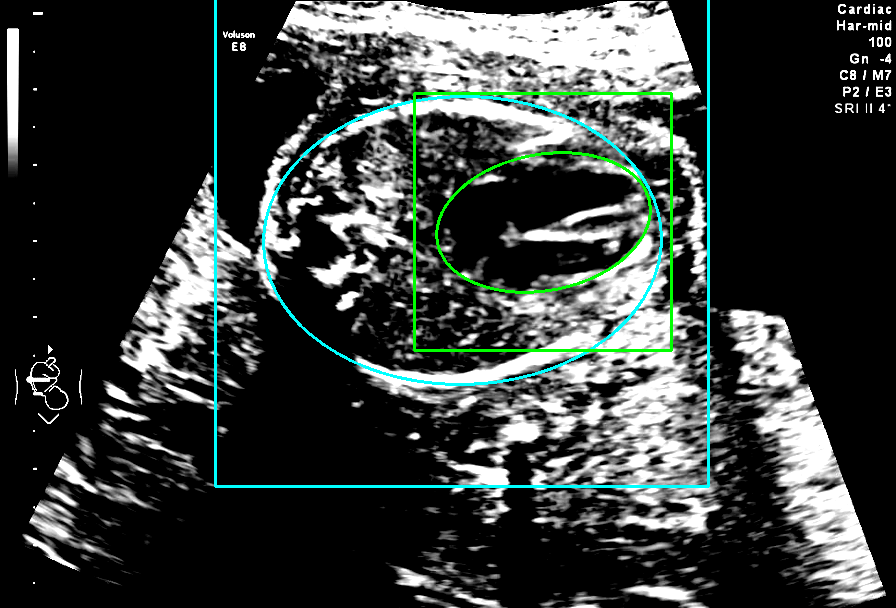

In [13]:
idx = 0

# Load Image
image = np.transpose(batch['input'][idx], (1, 2, 0)).numpy()
image = cv2.cvtColor(np.clip(image * 255, 0, 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
print(image.min(), image.max(), image.mean())
# plt.imshow(image)

# Inference
color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]

l = batch['l'][idx] * 4
ind = batch['ind'][idx]
reg = batch['reg'][idx]
cx = (ind % opt.output_res + reg[:, 0]) * 4
cy = (ind // opt.output_res + reg[:, 1]) * 4
hm = batch['hm'][idx]
ratio_als = batch['ratio_al'][idx]
ratio_bls = batch['ratio_bl'][idx]
theta = batch['theta'][idx]

for class_idx in range(2):
#     class_id = class_idx + 1
#     pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
#     pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
#     cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
#     l = int(ret['results'][class_id][0, 6]) # !attention here!
#     ratio_al = ret['results'][class_id][0, 7]
#     ratio_ba = ret['results'][class_id][0, 8]
#     a = ratio_al * l
#     b = ratio_ba * a
#     theta = ret['results'][class_id][0, 9]
#     angle = theta * 180
#     print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, "({})'".format(theta), int(a), int(b), int(angle))
    
    # Annotations
    cx_gt, cy_gt = int(cx[class_idx]), int(cy[class_idx])
    a_gt = int(ratio_als[class_idx] * l[class_idx] / 2)
    b_gt = int(ratio_bls[class_idx] * l[class_idx] / 2)
    theta_gt = theta[class_idx]
    l_gt = l[class_idx]
#     l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
    pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
    pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
    ratio_al, ratio_bl = 2 * a_gt / l_gt, 2 * b_gt / l_gt
    angle_gt = int(theta_gt * 180)
    print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_bl, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
#     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
#     img = cv2.ellipse(img, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, (255, 0, 0), thickness=2)
    img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
    img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)
    
    
#     pt1 = (int(cx - l / 2), int(cy - l / 2))
#     pt2 = (int(cx + l / 2), int(cy + l / 2))
#     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
#     img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)
    
img = Image.fromarray(image)
img
# img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

460 240 199 144 -1
540 220 108 68 -11


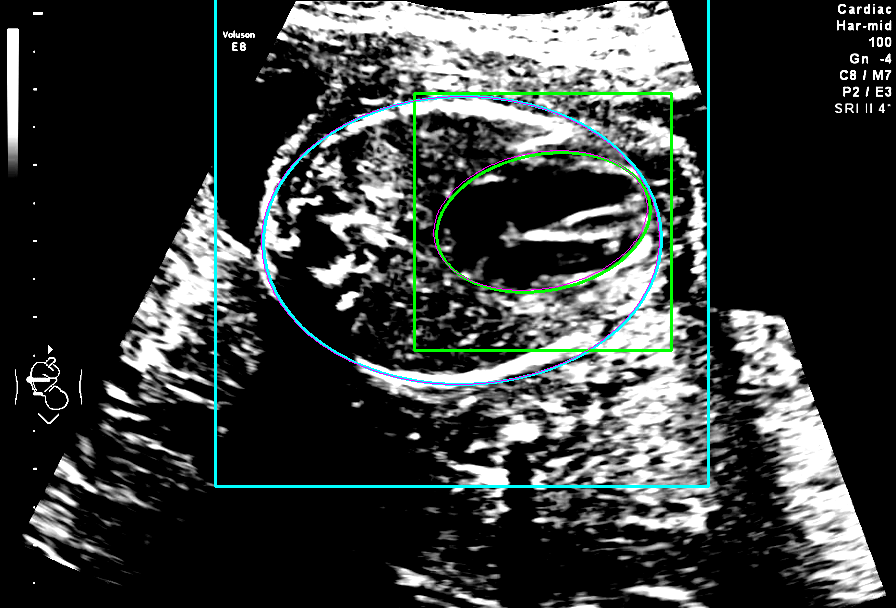

In [14]:
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].cpu()   
        
temp_label = decode_label_4iou(batch)
temp_decode = temp_label[0, :]
for class_idx in range(2):
    temp = temp_decode[class_idx]
    cx, cy, a, b, theta = temp
    cx, cy, a, b = int(cx), int(cy), int(a/2), int(b/2)
    angle = int(theta / math.pi * 180)
    img = cv2.ellipse(image, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, (255, 0, 255), thickness=1)
    print(cx, cy, a, b, angle)
#     break
img = Image.fromarray(image)
img

460 240 199 144 -1
540 220 108 68 -11


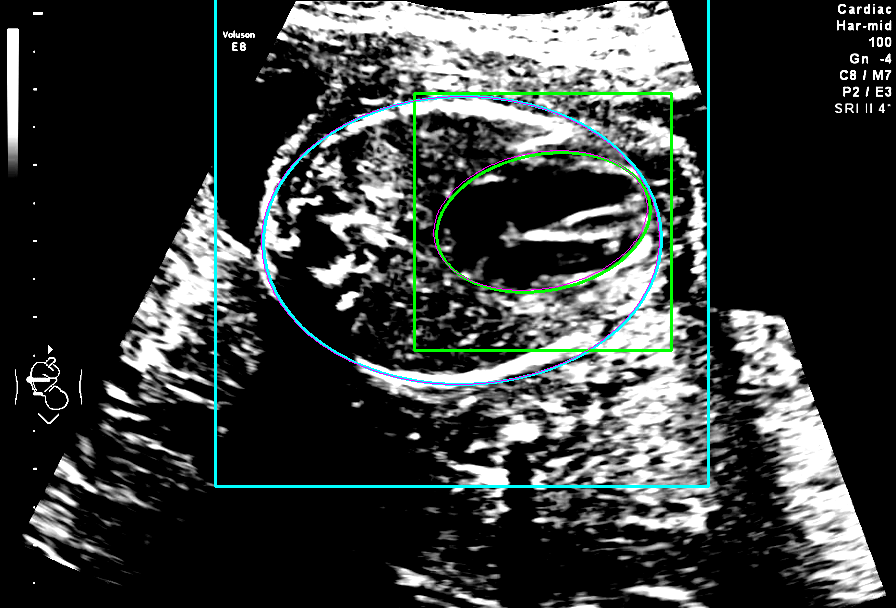

In [15]:
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].cuda()   

temp_label = decode_label_4iou(batch)
temp_decode = temp_label[0, :]
for class_idx in range(2):
    temp = temp_decode[class_idx]
    cx, cy, a, b, theta = temp
    cx, cy, a, b = int(cx), int(cy), int(a/2), int(b/2)
    angle = int(theta / math.pi * 180)
    img = cv2.ellipse(image, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, (255, 0, 255), thickness=1)
    print(cx, cy, a, b, angle)
#     break
img = Image.fromarray(image)
img

472 236 198 157 -6
544 220 104 68 -9


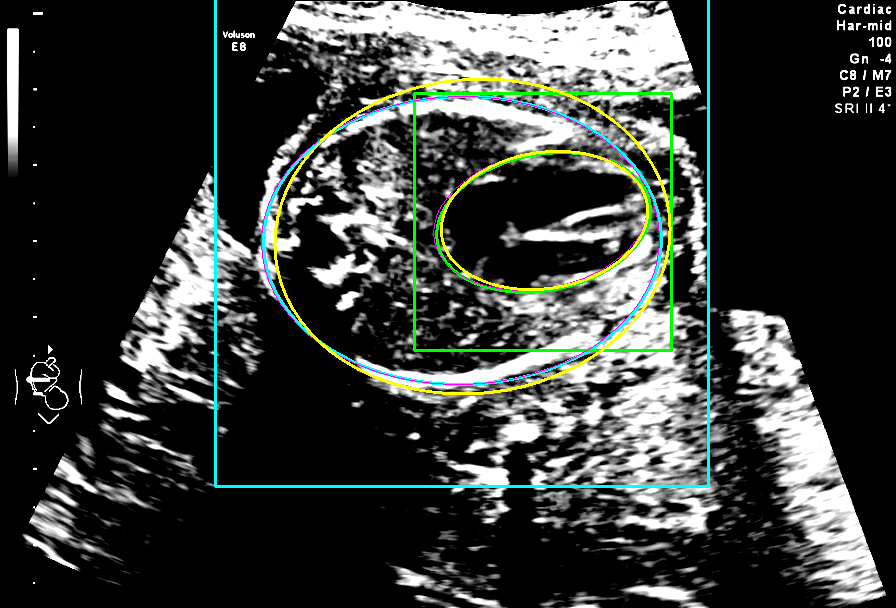

In [23]:
model = detector.model
output = model(batch['input'].cuda())
temp_pred = decode_output_4iou(output[0])
temp_output = temp_pred[0, :]
for class_idx in range(2):
    temp = temp_output[class_idx]
    cx, cy, a, b, theta = temp
    cx, cy, a, b = int(cx), int(cy), int(a/2), int(b/2)
    angle = int(theta / math.pi * 180)
    img = cv2.ellipse(image, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, (255, 255, 0), thickness=2)
    print(cx, cy, a, b, angle)
#     break
img = Image.fromarray(image)
img

In [24]:
batch['input'].shape, output[0]['hm'].shape


(torch.Size([16, 3, 608, 896]), torch.Size([16, 2, 152, 224]))

In [11]:
bbox_pred = decode_output_4iou(output[0])
bbox_label = decode_label_4iou(batch)
print(bbox_pred, bbox_label)
cal_diou(bbox_pred, bbox_label)

tensor([[[ 4.7252e+02,  2.3651e+02,  3.9781e+02,  3.1567e+02, -1.0964e-01],
         [ 5.4453e+02,  2.2048e+02,  2.0962e+02,  1.3652e+02, -1.7122e-01]]],
       device='cuda:0', grad_fn=<StackBackward>) tensor([[[ 4.6090e+02,  2.4056e+02,  2.1666e+02,  1.3671e+02, -1.9759e-01],
         [ 5.4058e+02,  2.2018e+02,  3.9915e+02,  2.8820e+02, -2.3593e-02]]],
       device='cuda:0')


(tensor([[0.7647, 0.7513]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[0.2359, 0.2488]], device='cuda:0', grad_fn=<DivBackward0>))

In [25]:
iou_loss = IoULoss()
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=opt.device, non_blocking=True)    
iou_loss(output[0], batch)

tensor([[[ 4.7252e+02,  2.3651e+02,  3.9781e+02,  3.1567e+02, -1.0964e-01],
         [ 5.4453e+02,  2.2048e+02,  2.0962e+02,  1.3652e+02, -1.7122e-01]],

        [[ 3.9252e+02,  3.3651e+02,  6.2339e+02,  5.0335e+02,  2.7420e-01],
         [ 2.6850e+02,  3.6457e+02,  3.0230e+02,  2.0592e+02, -3.2398e-01]],

        [[ 3.9652e+02,  2.8849e+02,  5.5016e+02,  4.6499e+02, -5.6297e-01],
         [ 4.0445e+02,  1.9644e+02,  2.7895e+02,  2.1912e+02, -5.2138e-01]],

        [[ 5.1652e+02,  2.7250e+02,  6.9220e+02,  5.4948e+02, -5.5390e-02],
         [ 4.0052e+02,  2.9256e+02,  3.7244e+02,  2.6931e+02, -5.1785e-01]],

        [[ 3.6452e+02,  3.0449e+02,  4.1694e+02,  3.3011e+02,  6.3132e-02],
         [ 4.6052e+02,  3.2852e+02,  2.0004e+02,  1.3988e+02,  2.9861e-01]],

        [[ 3.7651e+02,  2.7649e+02,  6.0533e+02,  4.7934e+02,  4.3560e-02],
         [ 2.6451e+02,  2.4053e+02,  3.2507e+02,  2.3807e+02,  7.2137e-01]],

        [[ 4.4451e+02,  2.8048e+02,  4.8879e+02,  3.9086e+02, -3.7801e-01],


(tensor([[0.1392, 0.0566],
         [0.1203, 0.1851],
         [0.2860, 0.3165],
         [0.1480, 0.1373],
         [0.1665, 0.2514],
         [0.1333, 0.0887],
         [0.2421, 0.1683],
         [0.1877, 0.1355],
         [0.1677, 0.1744],
         [0.2015, 0.0852],
         [0.2785, 0.2950],
         [0.1689, 0.1561],
         [0.1163, 0.2287],
         [0.2128, 0.1259],
         [0.2383, 0.1931],
         [0.1559, 0.1287]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[0.8613, 0.9436],
         [0.8802, 0.8159],
         [0.7145, 0.6844],
         [0.8531, 0.8630],
         [0.8335, 0.7486],
         [0.8668, 0.9114],
         [0.7594, 0.8318],
         [0.8127, 0.8662],
         [0.8326, 0.8275],
         [0.7987, 0.9149],
         [0.7223, 0.7118],
         [0.8323, 0.8440],
         [0.8843, 0.7713],
         [0.7877, 0.8748],
         [0.7623, 0.8073],
         [0.8450, 0.8720]], device='cuda:0', grad_fn=<DivBackward0>))

In [43]:
bbox_pred = decode_output_4iou(output[0])
bbox_label = decode_label_4iou_test(batch)
print(bbox_pred)
print(bbox_label)
cal_diou(bbox_pred, bbox_label)

tensor([[[ 4.7252e+02,  2.3651e+02,  3.9781e+02,  3.1567e+02, -1.0963e-01],
         [ 5.4453e+02,  2.2048e+02,  2.0962e+02,  1.3652e+02, -1.7122e-01]]],
       device='cuda:0', grad_fn=<StackBackward>)
tensor([[[ 4.6058e+02,  2.4018e+02,  3.9915e+02,  2.8820e+02, -2.3593e-02],
         [ 5.4090e+02,  2.2056e+02,  2.1666e+02,  1.3671e+02, -1.9759e-01]]],
       device='cuda:0')


(tensor([[0.1392, 0.0566]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[0.8613, 0.9436]], device='cuda:0', grad_fn=<DivBackward0>))

In [13]:
temp_pred, temp_label

(tensor([[[ 4.7252e+02,  2.3651e+02,  3.9781e+02,  3.1567e+02, -1.0963e-01],
          [ 5.4453e+02,  2.2048e+02,  2.0962e+02,  1.3652e+02, -1.7122e-01]]],
        device='cuda:0', grad_fn=<StackBackward>),
 tensor([[[ 4.6058e+02,  2.4018e+02,  3.9915e+02,  2.8820e+02, -2.3593e-02],
          [ 5.4090e+02,  2.2056e+02,  2.1666e+02,  1.3671e+02, -1.9759e-01]]]))

In [11]:
print(temp_label.shape, temp_label)
print(temp_pred.shape, temp_pred)
cal_diou(temp_pred.cuda(), temp_label.cuda())

torch.Size([1, 2, 5]) tensor([[[ 4.6058e+02,  2.4018e+02,  3.9915e+02,  2.8820e+02, -2.3593e-02],
         [ 5.4090e+02,  2.2056e+02,  2.1666e+02,  1.3671e+02, -1.9759e-01]]])
torch.Size([1, 2, 5]) tensor([[[ 4.7252e+02,  2.3651e+02,  3.9781e+02,  3.1567e+02, -1.0963e-01],
         [ 5.4453e+02,  2.2048e+02,  2.0962e+02,  1.3652e+02, -1.7122e-01]]],
       device='cuda:0', grad_fn=<StackBackward>)


(tensor([[0.1392, 0.0566]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[0.8613, 0.9436]], device='cuda:0', grad_fn=<DivBackward0>))

(torch.Size([1, 2, 5]), torch.Size([1, 2, 5]))

In [9]:
temp_output, clses = decode_output_4iou(output[0])
print(temp_output)
print(clses)
print(temp_output.shape, temp_label[0].shape)

tensor([[[ 5.4453e+02,  2.2048e+02,  2.0962e+02,  1.3652e+02, -1.7122e-01],
         [ 4.7252e+02,  2.3651e+02,  3.9781e+02,  3.1567e+02, -1.0963e-01]]],
       device='cuda:0', grad_fn=<CatBackward>)
tensor([[1, 0]], dtype=torch.int32)
torch.Size([1, 2, 5]) torch.Size([1, 2, 5])


In [44]:
from models.losses import *
from models.decode import _nms, _topk, _transpose_and_gather_feat
def decode_output_4iou_test(output, K=2): # Decode output for iou loss
    heat = F.sigmoid(output['hm']) # (B, 2, w, h)
    l = output['l'] * 4 # (B, 1, w, h)
    ratio_al = output["ratio_al"] # (B, 1, w, h)
    ratio_bl = output["ratio_bl"] # (B, 1, w, h)
    theta = output["theta"] # (B, 2, w, h)
    reg = output['reg'] # (B, 2, w, h)

    batch, cat, height, width = heat.size()
    heat = _nms(heat)
    scores, inds, clses, ys, xs = _topk(heat, K=K)

    if reg is not None:
        reg = _transpose_and_gather_feat(reg, inds)  # (B, K, 1)
        reg = reg.view(batch, K, 2)
        xs = xs.view(batch, K, 1) * 4 + reg[:, :, 0:1]
        ys = ys.view(batch, K, 1) * 4 + reg[:, :, 1:2]
    else:
        xs = xs.view(batch, K, 1) * 4 + 0.5
        ys = ys.view(batch, K, 1) * 4 + 0.5

    l = _transpose_and_gather_feat(l, inds) # (B, K, 1)
    ratio_al = _transpose_and_gather_feat(ratio_al, inds) # (B, K, 1)
    ratio_bl = _transpose_and_gather_feat(ratio_bl, inds) # (B, K, 1)
    theta = _transpose_and_gather_feat(theta, inds) # (B, K, 1)

    a = l * ratio_al / 2
    b = l * ratio_bl / 2
    angle = theta * math.pi

    bboxes = torch.cat([xs, ys, 2*a, 2*b, angle, clses.unsqueeze(-1)], dim=2)

    temp_boxes = []
    for batch_idx in range(batch):
        temp_box = []
        temp_box.append(bboxes[batch_idx, clses[batch_idx, 0], :])
        temp_box.append(bboxes[batch_idx, clses[batch_idx, 1], :])
        temp_box = torch.stack(temp_box, dim=0)
        temp_boxes.append(temp_box)
    bboxes = torch.stack(temp_boxes, dim=0)
    return bboxes

def decode_label_4iou_test(label, K=2): # Decode label for iou loss
    heat = label['hm']
    reg = label['reg']
    l = label['l'] * 4
    ratio_al = label['ratio_al']
    ratio_bl = label['ratio_bl']
    theta = label['theta']
    batch, cat, height, width = heat.size()
    
    ind = label['ind']
    reg = label['reg']
    xs = ind % opt.output_res
    ys = ind // opt.output_res
    print(height, width, opt.output_res)
#     clses = batch[]

    # perform nms on heatmaps
#     heat = _nms(heat)
      
#     scores, inds, clses, ys, xs = _topk(heat, K=K) # (B, K)
    if reg is not None:
        reg = reg.view(batch, K, 2)
        xs = xs.view(batch, K, 1) * 4 + reg[:, :, 0:1]
        ys = ys.view(batch, K, 1) * 4 + reg[:, :, 1:2]
    else:
        xs = xs.view(batch, K, 1) * 4 + 0.5
        ys = ys.view(batch, K, 1) * 4 + 0.5
    a = l * ratio_al / 2
    b = l * ratio_bl / 2
    angle = theta * math.pi
#     print("cord: ", xs, ys, clses)
#     print("ratio: ", ratio_al, ratio_bl)

    bboxes = torch.cat([xs, ys, 2*a, 2*b, angle], dim=2)
#     print(bboxes)
#     temp_boxes = []
#     for batch_idx in range(batch):
#         temp_box = []
#         temp_box.append(bboxes[batch_idx, clses[batch_idx, 0], :])
#         temp_box.append(bboxes[batch_idx, clses[batch_idx, 1], :])
#         temp_box = torch.stack(temp_box, dim=0)
#         temp_boxes.append(temp_box)
#     bboxes = torch.stack(temp_boxes, dim=0)
    return bboxes

In [28]:
label = batch
ind = label['ind']
reg = label['reg']
xs = (ind % opt.output_res + reg[:, 0]) * 4
ys = (ind // opt.output_res + reg[:, 1]) * 4
xs, ys

(tensor([[462.3175, 540.7258]]), tensor([[243.6041, 222.2515]]))

In [45]:
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].cuda() 
temp_label = decode_label_4iou_test(batch)
print(temp_label)
print("========================")
# for k in batch:
#     if k != 'meta':
#         batch[k] = batch[k].cpu()   
# temp_label = decode_label_4iou_test(batch)
# print(temp_label)

152 224 224
tensor([[[ 4.6058e+02,  2.4018e+02,  3.9915e+02,  2.8820e+02, -2.3593e-02],
         [ 5.4090e+02,  2.2056e+02,  2.1666e+02,  1.3671e+02, -1.9759e-01]]],
       device='cuda:0')


In [67]:
model = detector.model
output = model(batch['input'].cuda())

In [70]:
print(decode_output_4iou(output[0]))
temp_output = decode_output_4iou_test(output[0])
temp_output

(tensor([[[ 5.4453e+02,  2.2048e+02,  2.0962e+02,  1.3652e+02, -1.7122e-01],
         [ 4.7252e+02,  2.3651e+02,  3.9781e+02,  3.1567e+02, -1.0964e-01]],

        [[ 2.6850e+02,  3.6457e+02,  3.0230e+02,  2.0592e+02, -3.2398e-01],
         [ 3.9252e+02,  3.3651e+02,  6.2339e+02,  5.0335e+02,  2.7420e-01]],

        [[ 4.0445e+02,  1.9644e+02,  2.7895e+02,  2.1912e+02, -5.2138e-01],
         [ 3.9652e+02,  2.8849e+02,  5.5016e+02,  4.6499e+02, -5.6297e-01]],

        [[ 4.0052e+02,  2.9256e+02,  3.7244e+02,  2.6931e+02, -5.1785e-01],
         [ 5.1652e+02,  2.7250e+02,  6.9220e+02,  5.4948e+02, -5.5390e-02]],

        [[ 4.6052e+02,  3.2852e+02,  2.0004e+02,  1.3988e+02,  2.9861e-01],
         [ 3.6452e+02,  3.0449e+02,  4.1694e+02,  3.3011e+02,  6.3132e-02]],

        [[ 2.6451e+02,  2.4053e+02,  3.2507e+02,  2.3807e+02,  7.2137e-01],
         [ 3.7651e+02,  2.7649e+02,  6.0533e+02,  4.7934e+02,  4.3560e-02]],

        [[ 3.8456e+02,  3.2053e+02,  2.5294e+02,  1.8856e+02, -7.3297e-01],

tensor([[[ 4.7252e+02,  2.3651e+02,  3.9781e+02,  3.1567e+02, -1.0964e-01,
           0.0000e+00],
         [ 5.4453e+02,  2.2048e+02,  2.0962e+02,  1.3652e+02, -1.7122e-01,
           1.0000e+00]],

        [[ 3.9252e+02,  3.3651e+02,  6.2339e+02,  5.0335e+02,  2.7420e-01,
           0.0000e+00],
         [ 2.6850e+02,  3.6457e+02,  3.0230e+02,  2.0592e+02, -3.2398e-01,
           1.0000e+00]],

        [[ 3.9652e+02,  2.8849e+02,  5.5016e+02,  4.6499e+02, -5.6297e-01,
           0.0000e+00],
         [ 4.0445e+02,  1.9644e+02,  2.7895e+02,  2.1912e+02, -5.2138e-01,
           1.0000e+00]],

        [[ 5.1652e+02,  2.7250e+02,  6.9220e+02,  5.4948e+02, -5.5390e-02,
           0.0000e+00],
         [ 4.0052e+02,  2.9256e+02,  3.7244e+02,  2.6931e+02, -5.1785e-01,
           1.0000e+00]],

        [[ 3.6452e+02,  3.0449e+02,  4.1694e+02,  3.3011e+02,  6.3132e-02,
           0.0000e+00],
         [ 4.6052e+02,  3.2852e+02,  2.0004e+02,  1.3988e+02,  2.9861e-01,
           1.0000e+00]],

